In [ ]:
%pip install torch transformers optuna seaborn torchmetrics iterative-stratification

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix, classification_report, f1_score, accuracy_score
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import optuna
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AutoModel
from torchmetrics.classification import MultilabelHammingDistance
import time
import datetime
import pickle
# from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
import os

In [ ]:
# DATA_FPATH = '/dbfs/FileStore/citation_intent/software_intent_data___final_data.csv'
DATA_FPATH = '/dbfs/FileStore/citation_intent/final_df_w_unlabeled.csv'
OUTPUT_PATH = '/dbfs/FileStore/citation_intent/'

df = pd.read_csv(DATA_FPATH, index_col=None)
# df = df.drop(['Unnamed: 6'], axis=1)

In [ ]:
df

,id,sentence,used,created,mention
0,PMC5189946,All of this analysis was implemented using Mat...,False,True,False
1,PMC4511233,"Code for calculating partition similarity, obt...",False,True,False
2,PMC4186879,All behavioral statistical analyses were perfo...,False,False,True
3,PMC5026371,"M-Track was written using Python 2.7, OpenCV 3...",True,False,False
4,PMC1283974,"Mindboggle is a freely downloadable, open sour...",False,True,False
...,...,...,...,...,...
4212,PMC3579796,"To that end, each hen was gently maintained ap...",False,False,False
4213,PMC4701393,"Immediately before the odor is presented, the ...",False,False,False
4214,PMC4153588,Samples were collected seven times on an ordin...,False,False,False
4215,PMC4701393,This scale consists of six verbal and five per...,False,False,False


In [ ]:
df['used'] = df['used'].replace(True, 'used')
df['created'] = df['created'].replace(True, 'created')
df['mention'] = df['mention'].replace(True, 'mention')

In [ ]:
df['label'] = df[['used', 'created', 'mention']].values.tolist()
df['label'] = df['label'].apply(lambda x: [i for i in x if i])
df['label'] = df['label'].apply(lambda x: x if len(x)>0 else ['unlabeled'])
df = df.reset_index()

In [ ]:
df

,index,id,sentence,used,created,mention,label
0,0,PMC5189946,All of this analysis was implemented using Mat...,False,created,False,[created]
1,1,PMC4511233,"Code for calculating partition similarity, obt...",False,created,False,[created]
2,2,PMC4186879,All behavioral statistical analyses were perfo...,False,False,mention,[mention]
3,3,PMC5026371,"M-Track was written using Python 2.7, OpenCV 3...",used,False,False,[used]
4,4,PMC1283974,"Mindboggle is a freely downloadable, open sour...",False,created,False,[created]
...,...,...,...,...,...,...,...
4212,4212,PMC3579796,"To that end, each hen was gently maintained ap...",False,False,False,[unlabeled]
4213,4213,PMC4701393,"Immediately before the odor is presented, the ...",False,False,False,[unlabeled]
4214,4214,PMC4153588,Samples were collected seven times on an ordin...,False,False,False,[unlabeled]
4215,4215,PMC4701393,This scale consists of six verbal and five per...,False,False,False,[unlabeled]


In [ ]:
df['word_count'] = df['sentence'].apply(lambda x: len(x.split()))

array([[<Axes: title={'center': 'word_count'}>]], dtype=object)

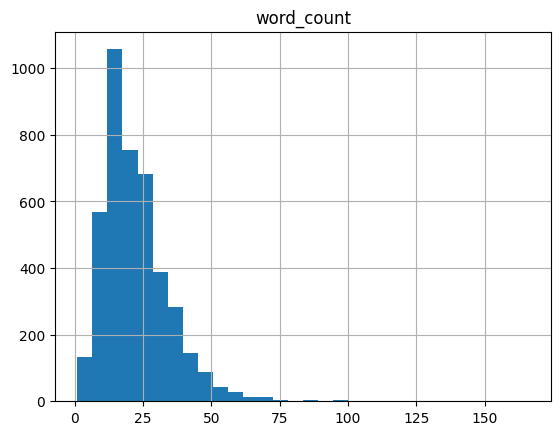

In [ ]:
df.hist('word_count', bins=30)

In [ ]:
# CLASSES = ['Created', 'Used', 'Mention']
CLASSES = ['used', 'created', 'mention', 'unlabeled']

In [ ]:
def vectorize_labels(df_y):
    """
    Transform labels into one-hot encoded vector representation
    """
    mlb = MultiLabelBinarizer()
    vectorized_y = mlb.fit_transform(df_y)

    return mlb, vectorized_y

mlb, vectorized_labels = vectorize_labels(df['label'])

df['vectorized_labels'] = vectorized_labels.tolist()

with open(f"{OUTPUT_PATH}/multilabel_binarizer.pkl", "wb") as f:
    pickle.dump(mlb, f)

In [ ]:
df = df[~df['label'].apply(lambda x: len(x)>1)].reset_index()

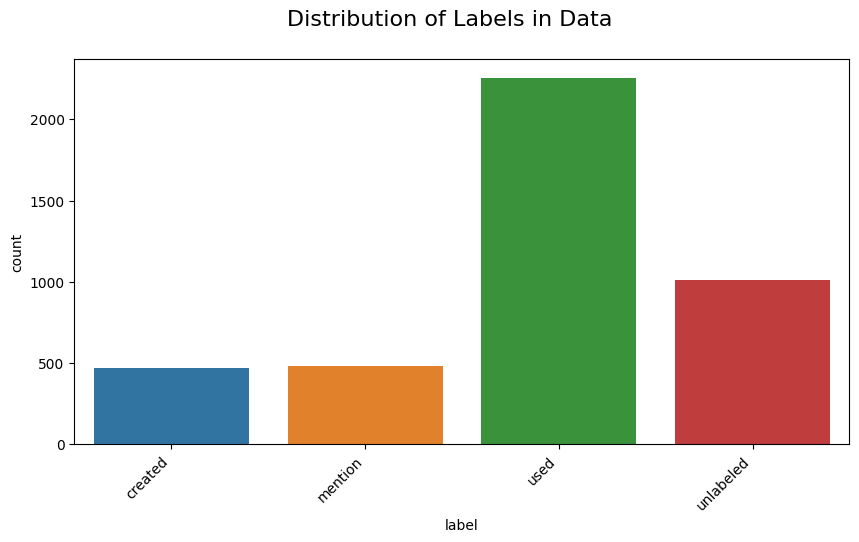

In [ ]:
explode_df = df.explode('label')
plt.figure(figsize=(10,5))
plt.suptitle("Distribution of Labels in Data", fontsize=16)
countplot = sns.countplot(data=explode_df, x="label")
countplot.set_xticklabels(countplot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
class SoftwareDataset(Dataset):
    """
    Custom dataset class that inherits from torch.utils.data.Dataset

    Makes use of Hugging Face transformer encode_plus method to:
        -Split sentence into tokens
        -Add special [CLS] and [SEP] tokens
        -Map tokens to IDs
        -Pad/truncate sentences to max length
        -Create attention masks

    Parameters
    ----------

    dataframe: pd.DataFrame used for model training, contains columns 'text' and vectorized labels 'target_list'
    tokenizer: tokenizer from transformers library used to prepare inputs for model
    max_len: maximum length (in number of tokens) for the inputs to model

    Returns
    _______

    dict: Dictionary of encoded ids, mask, token_type_ids, and targets

    """

    def __init__(self, dataframe, max_len):
        self.tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
        self.data = dataframe
        self.text = self.data.sentence
        self.targets = self.data.vectorized_labels
        self.max_len = max_len

    def __len__(self): # overrides __len__ so that len(dataset) returns size of dataset
        return len(self.text)

    def __getitem__(self, index): #override __getitem__ to support indexing
        text = str(self.text[index])
        text = ' '.join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens = True,
            max_length = self.max_len,
            padding='max_length',
            return_token_type_ids = True,
            truncation = True
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
def split_data(df, test_size):
    """
    Utility function to create train and validation datasets using stratified
    shuffling for multi-label data via iterstrat package
    
    Parameters
    ----------
    
    df: pd.DataFrame that contains modeling data
    test_size: float that designates proportion of data used for testing

    Returns
    -------
    train_dataset: pd.DataFrame that contains training samples
    valid_dataset: pd.DataFrame that contains validation samples
    """  

    x = df['sentence'].tolist()
    y= df['vectorized_labels'].tolist()
    sss = StratifiedShuffleSplit(n_splits=2, test_size=test_size, random_state=18)
    for train_index, valid_index in sss.split(x, y):
        train_dataset, valid_dataset = df.loc[train_index].reset_index(drop=True), df.loc[valid_index].reset_index(drop=True)
        
    print("FULL Dataset: {}".format(df.shape))
    print("TRAIN Dataset: {}".format(train_dataset.shape))
    print("TEST Dataset: {}".format(valid_dataset.shape))

    return train_dataset, valid_dataset
train_dataset, valid_dataset = split_data(df, 0.2)

FULL Dataset: (4215, 10)
TRAIN Dataset: (3372, 10)
TEST Dataset: (843, 10)


In [ ]:
class BERTClass(torch.nn.Module):
    """
    Fine tune a pre-trained BERT model, adjusted to learn our labels

    Contains a dropout layer that aims to minimize overfitting and a final linear layer that inputs
    768 dimension features from BERT and returns number of target features

    Forward method is used to feed input to BERT

    Parameters
    ----------
    bert_model_name: pre-trained model to use for fine-tuning
    dropout: float value to minimize overfitting
    classes_len: number of target labels
    """
    def __init__(self, dropout, classes_len):
        super(BERTClass, self).__init__()
        self.l1 = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")
        self.l2 = torch.nn.Dropout(dropout)
        self.l3 = torch.nn.Linear(768, 4)

    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict = False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

def prepare_loaders(train_dataset, valid_dataset, max_len, batch_size, num_workers):
    """
    Utility function that uses torch.utils.data.DataLoader class to create iterable over a dataset

    Parameters
    ----------
    Calls ConsortDataSet class to tokenize and encode text. See docstring for more info
        train_dataset
        valid_dataset
        tokenizer
        max_len

    batch_size: int for how many samples per batch to load
    num_workers: int for how many subprocesses to use for data loading

    Returns
    -------
    training_loader: iterable training dataset
    validation_loader: iterable validation dataset
    """


    training_set = SoftwareDataset(train_dataset, max_len)

    training_loader = DataLoader(
        training_set,
        batch_size = batch_size,
        shuffle = True,
        num_workers = num_workers)

    validation_set = SoftwareDataset(valid_dataset, max_len)

    validation_loader = DataLoader(
        validation_set,
        batch_size = batch_size,
        shuffle = True,
        num_workers = num_workers)

    return training_loader, validation_loader

def train(model, training_loader, optimizer, epoch, pos_weight, device):
    """
    For each batch of training data:
        1. Unpack batch from training loader
        2. Isolate batch ids, mask, token_type_ids and target values
        3. Perform a forward pass over data
        4. Clear previously calculated gradients
        5. Calculate loss
        6. Clear gradients
        7. Perform backward pass to calculate gradients
        8. Update parameters and take step using computed gradient

    Parameters
    ----------

    model: model class object to be trained
    training_loader: iterable dataset used to train
    optimizer: optimizer to be used to update parameters
    epoch: maximum number of epochs to be trained on
    pos_weight: class weighting to be used in loss function
    """

    model.train() #set model to training mode
    for batch_idx, data in enumerate(training_loader):   #1
        # print('epoch', batch_idx)
        ids = data['ids'].to(device, dtype = torch.long)    #2
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids) #3

        optimizer.zero_grad()   #4
        # loss = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)(outputs, targets)   #5
        loss = torch.nn.CrossEntropyLoss(weight=pos_weight)(outputs, targets)
        optimizer.zero_grad()  #6
        loss.backward()  #7
        optimizer.step()  #8

        if batch_idx%5000==0:
           print(f'Epoch: {epoch}, batch_id: {batch_idx}, Training Loss:  {loss.item()}')


def test(model, validation_loader, valid_loss_input, pos_weight, device):
    """
    For each batch of testing data:
        1.Tell pytorch not to both constructing the compute graph during forward pass since only needed for backprop
        2. Unpack batch from validation loader
        3. Isolate batch ids, mask, token_type_ids and target values
        4. Calculate predictions
        5. Calculate loss
        6. Accumulate validation loss
        7/8. Move labels and predictions to CPU and append to lists

    Parameters
    ----------

    model: trained model to validate
    validation_loader: iterable dataset used to validate
    valid_loss_input: initial input loss value
    pos_weight: class weighting to be used in loss function

    Returns
    -------

    val_targets: list of true validation targets
    val_outputs: list of predicated validation targets
    """

    model.eval() #put model in evaluation mode
    valid_loss = 0
    valid_loss_min = valid_loss_input
    val_targets = []
    val_outputs = []

    with torch.no_grad(): #1
      for batch_idx, data in enumerate(validation_loader, 0):   #2
            ids = data['ids'].to(device, dtype = torch.long)    #3
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)   #4

            # loss = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)(outputs, targets) #5
            loss = torch.nn.CrossEntropyLoss(weight=pos_weight)(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))  #6
            val_targets.extend(targets.cpu().detach().numpy().tolist())  #7
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())   #8



    print(f'Validation Loss: {valid_loss}')

    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).'.format(valid_loss_min,valid_loss))
        valid_loss_min = valid_loss

    return val_targets, val_outputs, valid_loss_min

def predict_and_score(val_targets, val_outputs, pred_threshold):
    """
    Calculate accuracy, f1_macro, and f1_micro using sklearn.metrics library

    Parameters
    ----------

    val_targets: list of true validation targets
    val_outputs: list of predicated validation targets

    Returns
    -------

    f1_score_macro: skelarn.metrics.f1_score with average='macro'
    """

    val_preds = (np.array(val_outputs) > pred_threshold).astype(int)

    f1_score_macro = f1_score(val_targets, val_preds, average='macro')

    return f1_score_macro

def pos_weights(df, classes_len):
    """
    Calculate weights for each class. Returns np.tobytes() because torch tensor isn't
    compatibilite with Optuna.trial.Trial.suggest_categorical()
    
    Parameters
    ----------
    
    df: pd.DataFrame
    classes_len: int number of classes in dataset
    
    Returns
    -------
     
    torch tensor of length number of classes
    """
    pos_counts = np.array(df["vectorized_labels"].values.tolist()).sum(axis=0)
    n_samples = len(df)
    
    weights = n_samples / (classes_len * pos_counts)

    return tuple(weights)


def run(trial, train_dataset, valid_dataset):
    """
    Train BERT model for fine tuning on data

    -Uses Optuna to define and train hyperparameters found in CONFIG
    -Loads training and validation loaders
    -Trains model
    -Returns macro F1 score that Optuna uses to maximize and tune parameters

    Parameters
    ----------

    train_dataset: pd.DataFrame that contains training samples
    valid_dataset: pd.DataFrame that contains validation samples

    Returns
    -------

    f1_score_macro: objective measure


    """
    CONFIG = {
        'seed': 42,
        'max_len': trial.suggest_categorical('max_len', [128]),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64]),
        'num_workers': 0,
        'classes_len': len(CLASSES),
        'optimizer': trial.suggest_categorical('optimizer', [torch.optim.Adam, torch.optim.AdamW]),
        'lr': trial.suggest_float('lr', 1e-5, 4e-4),
        'weight_decay': trial.suggest_float('weight_decay', 0, 0.1),
        'n_epochs': trial.suggest_int('n_epochs', 1, 8),
        'pred_threshold': trial.suggest_float('pred_threshold', 0.3, 0.6),
        'pos_weight': trial.suggest_categorical('pos_weight', [None, pos_weights(train_dataset, len(CLASSES))]),
        'dropout': trial.suggest_float('dropout', 0.0, 0.6),
        'device': "cuda",
        }

    device = torch.device(CONFIG['device'])
    model = BERTClass(CONFIG['dropout'], CONFIG['classes_len'])
    model.to(device)

    if CONFIG['pos_weight'] != None:
        pos_weight = torch.tensor(CONFIG['pos_weight'],dtype=torch.float).to(device, dtype = torch.float)
    else:
        pos_weight = CONFIG['pos_weight']

    torch.manual_seed(CONFIG['seed'])

    training_loader, validation_loader = prepare_loaders(train_dataset, valid_dataset, CONFIG['max_len'], CONFIG['batch_size'], CONFIG['num_workers'])

    optimizer = CONFIG['optimizer'](params =  model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])

    valid_loss_input = np.Inf

    for epoch in range(1, CONFIG['n_epochs']+1):

        train(model, training_loader, optimizer, epoch, pos_weight, device)
        val_targets, val_outputs, valid_loss_min = test(model, validation_loader, valid_loss_input, pos_weight, device)
        valid_loss_input = valid_loss_min

    f1_score_macro = predict_and_score(val_targets, val_outputs, CONFIG['pred_threshold'])

    print(f"F1 Score (Macro) = {f1_score_macro}")

    return f1_score_macro

if __name__ == '__main__':

    sampler = optuna.samplers.TPESampler(n_startup_trials=5)
    study = optuna.create_study(sampler=sampler, direction='maximize')
    start = time.time()
    study.optimize(lambda trial: run(trial, train_dataset, valid_dataset), n_trials=20)
    end = time.time()
    print('Time elapsed:', end - start)
    joblib.dump(study, f"{OUTPUT_PATH}/optuna_software_context_mentions.pkl")

[I 2023-10-26 20:33:31,941] A new study created in memory with name: no-name-209c769b-48e7-4765-a203-8288c4e3de36
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamw.AdamW'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a cat

Epoch: 1, batch_id: 0, Training Loss:  1.6132689714431763
Validation Loss: 1.4168911730801617
Validation loss decreased (inf --> 1.416891).
Epoch: 2, batch_id: 0, Training Loss:  1.5950239896774292
Validation Loss: 1.4248560446280019
Epoch: 3, batch_id: 0, Training Loss:  1.2150306701660156
Validation Loss: 1.4050713424329409
Validation loss decreased (1.416891 --> 1.405071).
Epoch: 4, batch_id: 0, Training Loss:  1.356712818145752
Validation Loss: 1.1314857867028978
Validation loss decreased (1.405071 --> 1.131486).
Epoch: 5, batch_id: 0, Training Loss:  1.1817259788513184
Validation Loss: 1.075026660053818
Validation loss decreased (1.131486 --> 1.075027).
Epoch: 6, batch_id: 0, Training Loss:  0.9767861366271973
Validation Loss: 1.0008502624653002
Validation loss decreased (1.075027 --> 1.000850).
Epoch: 7, batch_id: 0, Training Loss:  0.8145021796226501


[I 2023-10-26 20:36:05,440] Trial 0 finished with value: 0.4653347016166707 and parameters: {'max_len': 128, 'batch_size': 32, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.00036222532337013317, 'weight_decay': 0.0075038335979611855, 'n_epochs': 7, 'pred_threshold': 0.31460135807652984, 'pos_weight': (2.242021276595745, 2.1782945736434107, 1.0459057071960298, 0.46755407653910147), 'dropout': 0.07581254502308872}. Best is trial 0 with value: 0.4653347016166707.


Validation Loss: 0.9980814214105956
Validation loss decreased (1.000850 --> 0.998081).
F1 Score (Macro) = 0.4653347016166707


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamw.AdamW'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2.2

Epoch: 1, batch_id: 0, Training Loss:  1.479135274887085
Validation Loss: 0.4002435290151172
Validation loss decreased (inf --> 0.400244).
Epoch: 2, batch_id: 0, Training Loss:  0.3497631251811981


[I 2023-10-26 20:36:50,129] Trial 1 finished with value: 0.6249397994586924 and parameters: {'max_len': 128, 'batch_size': 32, 'optimizer': <class 'torch.optim.adamw.AdamW'>, 'lr': 0.0001809416848925797, 'weight_decay': 0.03551265172957261, 'n_epochs': 2, 'pred_threshold': 0.34126523367586364, 'pos_weight': None, 'dropout': 0.4266823216880847}. Best is trial 1 with value: 0.6249397994586924.


Validation Loss: 0.5458982879364931
F1 Score (Macro) = 0.6249397994586924


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamw.AdamW'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2.2

Epoch: 1, batch_id: 0, Training Loss:  1.6772677898406982


[I 2023-10-26 20:37:12,000] Trial 2 finished with value: 0.6792878412097612 and parameters: {'max_len': 128, 'batch_size': 64, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.0003028833396233714, 'weight_decay': 0.09546416710928335, 'n_epochs': 1, 'pred_threshold': 0.5815652109618797, 'pos_weight': (2.242021276595745, 2.1782945736434107, 1.0459057071960298, 0.46755407653910147), 'dropout': 0.5512668159023625}. Best is trial 2 with value: 0.6792878412097612.


Validation Loss: 0.5048239114029066
Validation loss decreased (inf --> 0.504824).
F1 Score (Macro) = 0.6792878412097612


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamw.AdamW'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2.2

Epoch: 1, batch_id: 0, Training Loss:  1.6114212274551392
Validation Loss: 1.3860180377960205
Validation loss decreased (inf --> 1.386018).
Epoch: 2, batch_id: 0, Training Loss:  1.6844890117645264
Validation Loss: 1.40025077925788
Epoch: 3, batch_id: 0, Training Loss:  1.2502589225769043
Validation Loss: 1.4147894426628398
Epoch: 4, batch_id: 0, Training Loss:  1.4857202768325806
Validation Loss: 1.4131780686201871
Epoch: 5, batch_id: 0, Training Loss:  1.5386903285980225
Validation Loss: 1.3944736410070349
Epoch: 6, batch_id: 0, Training Loss:  1.3661231994628906
Validation Loss: 1.38681408211037
Epoch: 7, batch_id: 0, Training Loss:  1.3111622333526611


[I 2023-10-26 20:39:46,582] Trial 3 finished with value: 0.0 and parameters: {'max_len': 128, 'batch_size': 32, 'optimizer': <class 'torch.optim.adamw.AdamW'>, 'lr': 0.00021818573279306334, 'weight_decay': 0.09162482240911775, 'n_epochs': 7, 'pred_threshold': 0.5846133334950772, 'pos_weight': (2.242021276595745, 2.1782945736434107, 1.0459057071960298, 0.46755407653910147), 'dropout': 0.32871961132734484}. Best is trial 2 with value: 0.6792878412097612.


Validation Loss: 1.39400550171181
F1 Score (Macro) = 0.0


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamw.AdamW'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2.2

Epoch: 1, batch_id: 0, Training Loss:  1.5001180171966553
Validation Loss: 0.30871747540576117
Validation loss decreased (inf --> 0.308717).
Epoch: 2, batch_id: 0, Training Loss:  0.2504061758518219
Validation Loss: 0.32403476642710827
Epoch: 3, batch_id: 0, Training Loss:  0.2530062198638916
Validation Loss: 0.2989611226533141
Validation loss decreased (0.308717 --> 0.298961).
Epoch: 4, batch_id: 0, Training Loss:  0.058400385081768036
Validation Loss: 0.36820670110838755
Epoch: 5, batch_id: 0, Training Loss:  0.05679966136813164


[I 2023-10-26 20:41:31,583] Trial 4 finished with value: 0.833539184945753 and parameters: {'max_len': 128, 'batch_size': 64, 'optimizer': <class 'torch.optim.adamw.AdamW'>, 'lr': 7.404316140057675e-05, 'weight_decay': 0.07071222065173641, 'n_epochs': 5, 'pred_threshold': 0.44824046711325005, 'pos_weight': (2.242021276595745, 2.1782945736434107, 1.0459057071960298, 0.46755407653910147), 'dropout': 0.019855535131188807}. Best is trial 4 with value: 0.833539184945753.


Validation Loss: 0.41673695828233454
F1 Score (Macro) = 0.833539184945753


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamw.AdamW'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2.2

Epoch: 1, batch_id: 0, Training Loss:  1.3935084342956543
Validation Loss: 0.35462136885949547
Validation loss decreased (inf --> 0.354621).
Epoch: 2, batch_id: 0, Training Loss:  0.36714115738868713
Validation Loss: 0.25848974181073053
Validation loss decreased (0.354621 --> 0.258490).
Epoch: 3, batch_id: 0, Training Loss:  0.10285471379756927
Validation Loss: 0.24904721230268478
Validation loss decreased (0.258490 --> 0.249047).
Epoch: 4, batch_id: 0, Training Loss:  0.06117868423461914


[I 2023-10-26 20:42:55,785] Trial 5 finished with value: 0.8165413782630108 and parameters: {'max_len': 128, 'batch_size': 64, 'optimizer': <class 'torch.optim.adamw.AdamW'>, 'lr': 2.6293770276773504e-05, 'weight_decay': 0.06394833602116515, 'n_epochs': 4, 'pred_threshold': 0.46294808736437393, 'pos_weight': None, 'dropout': 0.0005042905255400187}. Best is trial 4 with value: 0.833539184945753.


Validation Loss: 0.2512338273227215
F1 Score (Macro) = 0.8165413782630108


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamw.AdamW'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2.2

Epoch: 1, batch_id: 0, Training Loss:  1.462436318397522
Validation Loss: 0.5411401582615716
Validation loss decreased (inf --> 0.541140).
Epoch: 2, batch_id: 0, Training Loss:  0.5731735229492188
Validation Loss: 0.34392042351620544
Validation loss decreased (0.541140 --> 0.343920).
Epoch: 3, batch_id: 0, Training Loss:  0.22076410055160522
Validation Loss: 0.35378111260277884
Epoch: 4, batch_id: 0, Training Loss:  0.11449871212244034
Validation Loss: 0.3042416641754764
Validation loss decreased (0.343920 --> 0.304242).
Epoch: 5, batch_id: 0, Training Loss:  0.10985636711120605


[I 2023-10-26 20:44:40,872] Trial 6 finished with value: 0.7508023737484826 and parameters: {'max_len': 128, 'batch_size': 64, 'optimizer': <class 'torch.optim.adamw.AdamW'>, 'lr': 1.136133965023574e-05, 'weight_decay': 0.06190458734400411, 'n_epochs': 5, 'pred_threshold': 0.43282562605667785, 'pos_weight': (2.242021276595745, 2.1782945736434107, 1.0459057071960298, 0.46755407653910147), 'dropout': 0.1550713652279333}. Best is trial 4 with value: 0.833539184945753.


Validation Loss: 0.28963212562458857
Validation loss decreased (0.304242 --> 0.289632).
F1 Score (Macro) = 0.7508023737484826


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamw.AdamW'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2.2

Epoch: 1, batch_id: 0, Training Loss:  1.6322269439697266
Validation Loss: 0.3928094346608434
Validation loss decreased (inf --> 0.392809).
Epoch: 2, batch_id: 0, Training Loss:  0.3400396704673767
Validation Loss: 0.36850238697869436
Validation loss decreased (0.392809 --> 0.368502).
Epoch: 3, batch_id: 0, Training Loss:  0.13334152102470398
Validation Loss: 0.3406139463186264
Validation loss decreased (0.368502 --> 0.340614).
Epoch: 4, batch_id: 0, Training Loss:  0.08530363440513611


[I 2023-10-26 20:46:05,371] Trial 7 finished with value: 0.7913821791064926 and parameters: {'max_len': 128, 'batch_size': 64, 'optimizer': <class 'torch.optim.adamw.AdamW'>, 'lr': 0.00011343584590414957, 'weight_decay': 0.07606988616438036, 'n_epochs': 4, 'pred_threshold': 0.4576432364984283, 'pos_weight': (2.242021276595745, 2.1782945736434107, 1.0459057071960298, 0.46755407653910147), 'dropout': 0.20111420795968948}. Best is trial 4 with value: 0.833539184945753.


Validation Loss: 0.366439693740436
F1 Score (Macro) = 0.7913821791064926


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamw.AdamW'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2.2

Epoch: 1, batch_id: 0, Training Loss:  1.4146802425384521
Validation Loss: 0.31219931053263794
Validation loss decreased (inf --> 0.312199).
Epoch: 2, batch_id: 0, Training Loss:  0.3026081621646881
Validation Loss: 0.32725270411797935
Epoch: 3, batch_id: 0, Training Loss:  0.16742423176765442
Validation Loss: 0.33161068175520214
Epoch: 4, batch_id: 0, Training Loss:  0.19575166702270508
Validation Loss: 0.3259335224117551
Epoch: 5, batch_id: 0, Training Loss:  0.20187048614025116
Validation Loss: 0.43358932009765083
Epoch: 6, batch_id: 0, Training Loss:  0.30418962240219116
Validation Loss: 0.3323793826358659
Epoch: 7, batch_id: 0, Training Loss:  0.2707141041755676
Validation Loss: 0.38393164638962063
Epoch: 8, batch_id: 0, Training Loss:  0.2609424293041229


[I 2023-10-26 20:48:52,568] Trial 8 finished with value: 0.6963138987934957 and parameters: {'max_len': 128, 'batch_size': 64, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 9.863009168830766e-05, 'weight_decay': 0.03971794426456192, 'n_epochs': 8, 'pred_threshold': 0.39879768980251873, 'pos_weight': None, 'dropout': 0.0003584440927244456}. Best is trial 4 with value: 0.833539184945753.


Validation Loss: 0.47406129432576044
F1 Score (Macro) = 0.6963138987934957


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamw.AdamW'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2.2

Epoch: 1, batch_id: 0, Training Loss:  1.5482752323150635
Validation Loss: 0.4474468252488545
Validation loss decreased (inf --> 0.447447).
Epoch: 2, batch_id: 0, Training Loss:  0.4621189534664154
Validation Loss: 0.38125168638569973
Validation loss decreased (0.447447 --> 0.381252).
Epoch: 3, batch_id: 0, Training Loss:  0.184409961104393
Validation Loss: 0.3236986882984639
Validation loss decreased (0.381252 --> 0.323699).
Epoch: 4, batch_id: 0, Training Loss:  0.09350299835205078
Validation Loss: 0.3850560794983591
Epoch: 5, batch_id: 0, Training Loss:  0.12960770726203918


[I 2023-10-26 20:50:37,652] Trial 9 finished with value: 0.72397660561843 and parameters: {'max_len': 128, 'batch_size': 64, 'optimizer': <class 'torch.optim.adamw.AdamW'>, 'lr': 0.00011322870736596475, 'weight_decay': 0.07443163298340727, 'n_epochs': 5, 'pred_threshold': 0.4779792731610181, 'pos_weight': (2.242021276595745, 2.1782945736434107, 1.0459057071960298, 0.46755407653910147), 'dropout': 0.2327827167599796}. Best is trial 4 with value: 0.833539184945753.


Validation Loss: 0.38761932935033533
F1 Score (Macro) = 0.72397660561843


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamw.AdamW'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2.2

Epoch: 1, batch_id: 0, Training Loss:  1.3578813076019287
Validation Loss: 0.648963777003465
Validation loss decreased (inf --> 0.648964).
Epoch: 2, batch_id: 0, Training Loss:  0.7609120011329651
Validation Loss: 0.7482583147508126
Epoch: 3, batch_id: 0, Training Loss:  0.4176456928253174


[I 2023-10-26 20:51:44,654] Trial 10 finished with value: 0.6355711720283248 and parameters: {'max_len': 128, 'batch_size': 32, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.00021209814266304062, 'weight_decay': 0.0462251646842735, 'n_epochs': 3, 'pred_threshold': 0.5153456050569493, 'pos_weight': None, 'dropout': 0.12599288628717617}. Best is trial 4 with value: 0.833539184945753.


Validation Loss: 0.5199263548409497
Validation loss decreased (0.648964 --> 0.519926).
F1 Score (Macro) = 0.6355711720283248


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamw.AdamW'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2.2

Epoch: 1, batch_id: 0, Training Loss:  1.3458575010299683
Validation Loss: 0.3449640896703516
Validation loss decreased (inf --> 0.344964).
Epoch: 2, batch_id: 0, Training Loss:  0.35398709774017334
Validation Loss: 0.25309992049421587
Validation loss decreased (0.344964 --> 0.253100).
Epoch: 3, batch_id: 0, Training Loss:  0.08999602496623993
Validation Loss: 0.2660609590155738
Epoch: 4, batch_id: 0, Training Loss:  0.04650454223155975


[I 2023-10-26 20:53:08,955] Trial 11 finished with value: 0.7836391333784699 and parameters: {'max_len': 128, 'batch_size': 64, 'optimizer': <class 'torch.optim.adamw.AdamW'>, 'lr': 2.0445182678867352e-05, 'weight_decay': 0.06518943036887243, 'n_epochs': 4, 'pred_threshold': 0.4004532515094353, 'pos_weight': None, 'dropout': 0.023369933788047866}. Best is trial 4 with value: 0.833539184945753.


Validation Loss: 0.2552054151892662
F1 Score (Macro) = 0.7836391333784699


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamw.AdamW'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2.2

Epoch: 1, batch_id: 0, Training Loss:  1.4170558452606201
Validation Loss: 0.2686879070741789
Validation loss decreased (inf --> 0.268688).
Epoch: 2, batch_id: 0, Training Loss:  0.22715406119823456
Validation Loss: 0.25259698395218166
Validation loss decreased (0.268688 --> 0.252597).
Epoch: 3, batch_id: 0, Training Loss:  0.06161312013864517
Validation Loss: 0.30400405717747553
Epoch: 4, batch_id: 0, Training Loss:  0.07696433365345001
Validation Loss: 0.303014085228954
Epoch: 5, batch_id: 0, Training Loss:  0.13795286417007446
Validation Loss: 0.3290892307247434
Epoch: 6, batch_id: 0, Training Loss:  0.021063290536403656


[I 2023-10-26 20:55:15,138] Trial 12 finished with value: 0.8323950846001721 and parameters: {'max_len': 128, 'batch_size': 64, 'optimizer': <class 'torch.optim.adamw.AdamW'>, 'lr': 5.7718418744101004e-05, 'weight_decay': 0.05830934887771915, 'n_epochs': 6, 'pred_threshold': 0.5138626116959413, 'pos_weight': None, 'dropout': 0.004188929109411509}. Best is trial 4 with value: 0.833539184945753.


Validation Loss: 0.3347216940351895
F1 Score (Macro) = 0.8323950846001721


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamw.AdamW'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2.2

Epoch: 1, batch_id: 0, Training Loss:  1.4697681665420532
Validation Loss: 0.3248633103711265
Validation loss decreased (inf --> 0.324863).
Epoch: 2, batch_id: 0, Training Loss:  0.32743126153945923
Validation Loss: 0.2826417141727039
Validation loss decreased (0.324863 --> 0.282642).
Epoch: 3, batch_id: 0, Training Loss:  0.12598678469657898
Validation Loss: 0.2560515031218529
Validation loss decreased (0.282642 --> 0.256052).
Epoch: 4, batch_id: 0, Training Loss:  0.07309100031852722
Validation Loss: 0.32126688744340626
Epoch: 5, batch_id: 0, Training Loss:  0.025450151413679123
Validation Loss: 0.405750361936433
Epoch: 6, batch_id: 0, Training Loss:  0.03928804397583008


[I 2023-10-26 20:57:21,492] Trial 13 finished with value: 0.8320828376944298 and parameters: {'max_len': 128, 'batch_size': 64, 'optimizer': <class 'torch.optim.adamw.AdamW'>, 'lr': 8.246217019939104e-05, 'weight_decay': 0.0533609679919179, 'n_epochs': 6, 'pred_threshold': 0.5206633142342406, 'pos_weight': None, 'dropout': 0.08850673364241787}. Best is trial 4 with value: 0.833539184945753.


Validation Loss: 0.40926848884139744
F1 Score (Macro) = 0.8320828376944298


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamw.AdamW'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2.2

Epoch: 1, batch_id: 0, Training Loss:  1.5233230590820312
Validation Loss: 0.37843193113803864
Validation loss decreased (inf --> 0.378432).
Epoch: 2, batch_id: 0, Training Loss:  0.35721126198768616
Validation Loss: 0.3192745330078261
Validation loss decreased (0.378432 --> 0.319275).
Epoch: 3, batch_id: 0, Training Loss:  0.1652277112007141
Validation Loss: 0.33814194425940514
Epoch: 4, batch_id: 0, Training Loss:  0.0935547947883606
Validation Loss: 0.35298502338784077
Epoch: 5, batch_id: 0, Training Loss:  0.06210114061832428
Validation Loss: 0.3938551981534277
Epoch: 6, batch_id: 0, Training Loss:  0.07515771687030792


[I 2023-10-26 20:59:27,604] Trial 14 finished with value: 0.7950210767859887 and parameters: {'max_len': 128, 'batch_size': 64, 'optimizer': <class 'torch.optim.adamw.AdamW'>, 'lr': 7.150902172798073e-05, 'weight_decay': 0.08069232465961731, 'n_epochs': 6, 'pred_threshold': 0.5022896450695422, 'pos_weight': (2.242021276595745, 2.1782945736434107, 1.0459057071960298, 0.46755407653910147), 'dropout': 0.09735771382762085}. Best is trial 4 with value: 0.833539184945753.


Validation Loss: 0.41349683701992035
F1 Score (Macro) = 0.7950210767859887


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamw.AdamW'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2.2

Epoch: 1, batch_id: 0, Training Loss:  1.455475926399231
Validation Loss: 0.40597689683948246
Validation loss decreased (inf --> 0.405977).
Epoch: 2, batch_id: 0, Training Loss:  0.3853582739830017
Validation Loss: 0.35076800840241573
Validation loss decreased (0.405977 --> 0.350768).
Epoch: 3, batch_id: 0, Training Loss:  0.13234567642211914
Validation Loss: 0.3500069880059787
Validation loss decreased (0.350768 --> 0.350007).
Epoch: 4, batch_id: 0, Training Loss:  0.09111130237579346
Validation Loss: 0.38343965262174606
Epoch: 5, batch_id: 0, Training Loss:  0.12304380536079407
Validation Loss: 0.6042602381535939
Epoch: 6, batch_id: 0, Training Loss:  0.19505059719085693


[I 2023-10-26 21:01:33,616] Trial 15 finished with value: 0.7972744578545176 and parameters: {'max_len': 128, 'batch_size': 64, 'optimizer': <class 'torch.optim.adamw.AdamW'>, 'lr': 0.0001598442877977317, 'weight_decay': 0.030358454855414874, 'n_epochs': 6, 'pred_threshold': 0.5283463270807652, 'pos_weight': None, 'dropout': 0.1890491129951202}. Best is trial 4 with value: 0.833539184945753.


Validation Loss: 0.4437131317598479
F1 Score (Macro) = 0.7972744578545176


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamw.AdamW'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2.2

Epoch: 1, batch_id: 0, Training Loss:  1.451263666152954
Validation Loss: 0.3311465489012855
Validation loss decreased (inf --> 0.331147).
Epoch: 2, batch_id: 0, Training Loss:  0.2548491358757019
Validation Loss: 0.34658022171684677
Epoch: 3, batch_id: 0, Training Loss:  0.10660652071237564
Validation Loss: 0.3331595765692847
Epoch: 4, batch_id: 0, Training Loss:  0.06459116190671921
Validation Loss: 0.28294359307203976
Validation loss decreased (0.331147 --> 0.282944).
Epoch: 5, batch_id: 0, Training Loss:  0.0867721289396286
Validation Loss: 0.4959621663604464
Epoch: 6, batch_id: 0, Training Loss:  0.05628225952386856
Validation Loss: 0.40468574155654224
Epoch: 7, batch_id: 0, Training Loss:  0.05415549501776695
Validation Loss: 0.5116495734878949
Epoch: 8, batch_id: 0, Training Loss:  0.004344717133790255


[I 2023-10-26 21:04:21,355] Trial 16 finished with value: 0.8044816330206688 and parameters: {'max_len': 128, 'batch_size': 64, 'optimizer': <class 'torch.optim.adamw.AdamW'>, 'lr': 0.00014509983766118782, 'weight_decay': 0.054676034888416256, 'n_epochs': 8, 'pred_threshold': 0.552526366807257, 'pos_weight': None, 'dropout': 0.284682856831649}. Best is trial 4 with value: 0.833539184945753.


Validation Loss: 0.45800994975226267
F1 Score (Macro) = 0.8044816330206688


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamw.AdamW'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2.2

Epoch: 1, batch_id: 0, Training Loss:  1.5468353033065796
Validation Loss: 0.4048457933323724
Validation loss decreased (inf --> 0.404846).
Epoch: 2, batch_id: 0, Training Loss:  0.3987513780593872
Validation Loss: 0.3603315544979913
Validation loss decreased (0.404846 --> 0.360332).
Epoch: 3, batch_id: 0, Training Loss:  0.19617778062820435


[I 2023-10-26 21:05:24,953] Trial 17 finished with value: 0.7745495906575453 and parameters: {'max_len': 128, 'batch_size': 64, 'optimizer': <class 'torch.optim.adamw.AdamW'>, 'lr': 4.678820053593776e-05, 'weight_decay': 0.08418466661145904, 'n_epochs': 3, 'pred_threshold': 0.48046983476444466, 'pos_weight': (2.242021276595745, 2.1782945736434107, 1.0459057071960298, 0.46755407653910147), 'dropout': 0.07557234190646156}. Best is trial 4 with value: 0.833539184945753.


Validation Loss: 0.3560596640620913
Validation loss decreased (0.360332 --> 0.356060).
F1 Score (Macro) = 0.7745495906575453


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamw.AdamW'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2.2

Epoch: 1, batch_id: 0, Training Loss:  1.33132004737854
Validation Loss: 0.35147449760525307
Validation loss decreased (inf --> 0.351474).
Epoch: 2, batch_id: 0, Training Loss:  0.43396323919296265
Validation Loss: 0.34638942778110504
Validation loss decreased (0.351474 --> 0.346389).
Epoch: 3, batch_id: 0, Training Loss:  0.11742929369211197
Validation Loss: 0.36470598589490955
Epoch: 4, batch_id: 0, Training Loss:  0.21328313648700714
Validation Loss: 0.37190575069851345
Epoch: 5, batch_id: 0, Training Loss:  0.3442346453666687
Validation Loss: 0.3811073805446978
Epoch: 6, batch_id: 0, Training Loss:  0.1699095219373703
Validation Loss: 0.37231286090833177
Epoch: 7, batch_id: 0, Training Loss:  0.2327701598405838


[I 2023-10-26 21:07:59,853] Trial 18 finished with value: 0.6036807931636783 and parameters: {'max_len': 128, 'batch_size': 32, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 5.891322718210161e-05, 'weight_decay': 0.06911409460509066, 'n_epochs': 7, 'pred_threshold': 0.43491764886374135, 'pos_weight': None, 'dropout': 0.140776673790016}. Best is trial 4 with value: 0.833539184945753.


Validation Loss: 0.5315450772091196
F1 Score (Macro) = 0.6036807931636783


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamw.AdamW'> which is of type type.
  warnings.warn(message)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b8f46cb1-447b-406b-bf59-ea19b9c278a8/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2.2

Epoch: 1, batch_id: 0, Training Loss:  1.4997118711471558
Validation Loss: 0.40812833181449343
Validation loss decreased (inf --> 0.408128).
Epoch: 2, batch_id: 0, Training Loss:  0.33915501832962036
Validation Loss: 0.41313333277191433
Epoch: 3, batch_id: 0, Training Loss:  0.2685280442237854
Validation Loss: 0.44563062914780205
Epoch: 4, batch_id: 0, Training Loss:  0.16497300565242767
Validation Loss: 0.34760605330978117
Validation loss decreased (0.408128 --> 0.347606).
Epoch: 5, batch_id: 0, Training Loss:  0.2302575707435608


[I 2023-10-26 21:09:45,032] Trial 19 finished with value: 0.8213997690786201 and parameters: {'max_len': 128, 'batch_size': 64, 'optimizer': <class 'torch.optim.adamw.AdamW'>, 'lr': 0.0001168028361289839, 'weight_decay': 0.08659730108809818, 'n_epochs': 5, 'pred_threshold': 0.5536430298088009, 'pos_weight': (2.242021276595745, 2.1782945736434107, 1.0459057071960298, 0.46755407653910147), 'dropout': 0.052972590932764754}. Best is trial 4 with value: 0.833539184945753.


Validation Loss: 0.3713875040411949
F1 Score (Macro) = 0.8213997690786201
Time elapsed: 2173.090669155121


In [ ]:
optuna_scibert = joblib.load(f"{OUTPUT_PATH}/optuna_software_mentions.pkl")
best_params = optuna_scibert.best_params

In [ ]:
def run_best(train_dataset, valid_dataset, best_params):
    """
    Train BERT model for fine tuning on CONSORT data
    
    -Uses Optuna to define and train hyperparameters found in CONFIG
    -Loads training and validation loaders
    -Trains model
    -Returns macro F1 score that Optuna uses to maximize and tune parameters
    
    Parameters
    ----------
    
    train_dataset: pd.DataFrame that contains training samples
    valid_dataset: pd.DataFrame that contains validation samples
    
    Returns
    -------
    
    f1_score_macro: objective measure
    
    
    """

    CONFIG = {
        'seed': 42,
        'max_len': 'default',
        'batch_size': 'default',
        'num_workers': 0,
        'classes_len': len(CLASSES),
        'optimizer': 'default',
        'num_warmup_steps':'default',
        'lr': 'default',
        'weight_decay': 'default',
        'n_epochs': 'default',
        'pred_threshold': 'default',
        'pos_weight': 'default',
        'dropout': 'default',
        'device': "cuda"}

    CONFIG.update(best_params)
    joblib.dump(CONFIG, f"{OUTPUT_PATH}/config_scibert.pkl")
    
    model = BERTClass(CONFIG['dropout'], CONFIG['classes_len'])
    device = torch.device(CONFIG['device'])
    model.to(device)
    
    torch.manual_seed(CONFIG['seed'])

    if CONFIG['pos_weight'] != None:
        pos_weight = torch.tensor(CONFIG['pos_weight'],dtype=torch.float).to(device, dtype = torch.float)
    else:
        pos_weight = CONFIG['pos_weight']
    
    training_loader, validation_loader = prepare_loaders(train_dataset, valid_dataset, CONFIG['max_len'], CONFIG['batch_size'], CONFIG['num_workers'])
    
    optimizer = CONFIG['optimizer'](params =  model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
    
    valid_loss_input = np.Inf
    
    for epoch in range(1, CONFIG['n_epochs']+1):
        
        train(model, training_loader, optimizer, epoch, pos_weight, device)
        val_targets, val_outputs, valid_loss_min = test(model, validation_loader, valid_loss_input, pos_weight, device)
        valid_loss_input = valid_loss_min
        
    # micro_hamming_loss = predict_and_score(val_targets, val_outputs, CONFIG['pred_threshold'], CONFIG['classes_len'])
    # print(f"Hamming Loss (Micro) = {micro_hamming_loss}")
    f1_score_macro = predict_and_score(val_targets, val_outputs, CONFIG['pred_threshold'])

    print(f"F1 Score (Macro) = {f1_score_macro}")

    torch.save(model.state_dict(), f"{OUTPUT_PATH}/SciBERT_software_intent.pt")
    val_preds = (np.array(val_outputs) > CONFIG['pred_threshold']).astype(int)
    print(classification_report(val_targets, val_preds, target_names=mlb.classes_))

In [ ]:
run_best(train_dataset, valid_dataset, best_params)

Epoch: 1, batch_id: 0, Training Loss:  1.6253738403320312
Validation Loss: 0.3566967653376716
Validation loss decreased (inf --> 0.356697).
Epoch: 2, batch_id: 0, Training Loss:  0.3374609351158142
Validation Loss: 0.3775885168995176
Epoch: 3, batch_id: 0, Training Loss:  0.23997914791107178
Validation Loss: 0.32245428647313795
Validation loss decreased (0.356697 --> 0.322454).
Epoch: 4, batch_id: 0, Training Loss:  0.07606830447912216
Validation Loss: 0.3689432575234345
Epoch: 5, batch_id: 0, Training Loss:  0.04355796426534653
Validation Loss: 0.36896095212016783
F1 Score (Macro) = 0.8098151346177715
              precision    recall  f1-score   support

     created       0.72      0.99      0.83        94
     mention       0.51      0.92      0.66        96
   unlabeled       0.70      1.00      0.82       202
        used       0.91      0.95      0.93       451

   micro avg       0.76      0.96      0.85       843
   macro avg       0.71      0.96      0.81       843
weighted a


## Evaluation

In [ ]:
evaluation_df = pd.read_csv('/Workspace/Users/k.moraw@epcc.ed.ac.uk/data/software_citation_intent_czi.csv')
joss_df = pd.read_csv('/dbfs/FileStore/citation_intent/joss_creation.csv')
joss_df = joss_df.rename(columns={'intent':'label'})
joss_df = joss_df[['sentence', 'label']]
joss_df['label'] = joss_df['label'].replace('creation', 'created')
evaluation_df = evaluation_df[['text', 'Intent (creation, used, mention)']]
evaluation_df = evaluation_df.rename(columns={'text':'sentence', 'Intent (creation, used, mention)':'label'})
# evaluation_df['label'] = evaluation_df['label'].apply(lambda x: [x])
combined_df = pd.concat([evaluation_df, joss_df]).reset_index()

In [ ]:
combined_df['label'].value_counts()

used       344
mention     30
created     10
Name: label, dtype: int64

In [ ]:
config_path = f"{OUTPUT_PATH}/config_scibert.pkl"
state_dict = f"{OUTPUT_PATH}/SciBERT_software_intent.pt"

In [ ]:
class EvaluationSoftwareDataset(Dataset):
    """
    Custom dataset class that inherits from torch.utils.data.Dataset

    Makes use of Hugging Face transformer encode_plus method to:
        -Split sentence into tokens
        -Add special [CLS] and [SEP] tokens
        -Map tokens to IDs
        -Pad/truncate sentences to max length
        -Create attention masks

    Parameters
    ----------

    dataframe: pd.DataFrame used for model training, contains columns 'text' and vectorized labels 'target_list'
    tokenizer: tokenizer from transformers library used to prepare inputs for model
    max_len: maximum length (in number of tokens) for the inputs to model

    Returns
    _______

    dict: Dictionary of encoded ids, mask, token_type_ids, and targets

    """

    def __init__(self, dataframe, max_len):
        self.tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
        self.data = dataframe
        self.text = self.data.sentence
        self.max_len = max_len

    def __len__(self): # overrides __len__ so that len(dataset) returns size of dataset
        return len(self.text)

    def __getitem__(self, index): #override __getitem__ to support indexing
        text = str(self.text[index])
        text = ' '.join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens = True,
            max_length = self.max_len,
            padding='max_length',
            return_token_type_ids = True,
            truncation = True
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
        }

In [ ]:
def run_inference_and_score(valid_dataset):

    CONFIG = joblib.load(config_path)
    model = BERTClass(CONFIG['dropout'], CONFIG['classes_len'])


    if torch.cuda.is_available():
        model.load_state_dict(torch.load(state_dict, map_location=torch.device('cuda')))
        device = torch.device("cuda")
    else:
        model.load_state_dict(torch.load(state_dict, map_location=torch.device('cpu')))
        device = torch.device("cpu")
    model.to(device)


    validation_set = EvaluationSoftwareDataset(valid_dataset, CONFIG['max_len'])

    validation_loader = DataLoader(
        validation_set,
        batch_size = CONFIG['batch_size'],
        shuffle = False,
        num_workers = 0)
    
    model.eval() #put model in evaluation mode
    val_outputs = []

    with torch.no_grad(): #1
      for batch_idx, data in enumerate(validation_loader, 0):   #2
            ids = data['ids'].to(device, dtype = torch.long)    #3
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)   #4

            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    
    output_array = np.array(val_outputs)
    val_preds = (output_array == output_array.max(axis=1, keepdims=1)).astype(int)
    val_preds = mlb.inverse_transform(val_preds)
    val_preds = [i[0] for i in val_preds]
    

    # print(classification_report(val_targets, val_preds, target_names=mlb.classes_))
    return val_preds

In [ ]:
predictions = run_inference_and_score(combined_df)

In [ ]:
print(classification_report(combined_df['label'].tolist(), predictions, target_names=mlb.classes_))

              precision    recall  f1-score   support

     created       0.00      0.00      0.00        10
     mention       0.07      0.13      0.09        30
   unlabeled       0.00      0.00      0.00         0
        used       0.89      0.70      0.78       344

    accuracy                           0.64       384
   macro avg       0.24      0.21      0.22       384
weighted avg       0.80      0.64      0.71       384



/databricks/python/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
